# Necessary Libraries for preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings

import time

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import statsmodels.api as sm

# Some configuration
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Kaggle Configuration for Importing the data


In [2]:
# Installing kaggle
! pip install -q kaggle

In [4]:
# making file to upload the kaggle json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"psalisholsamuel","key":"0953b1f053e63b6a1fae6f276ed6004b"}'}

In [5]:
# making kaggle directory
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download ananaymital/us-used-cars-dataset

100% 2.13G/2.13G [00:21<00:00, 42.7MB/s]
100% 2.13G/2.13G [00:21<00:00, 106MB/s] 


In [9]:
! unzip us-used-cars-dataset.zip

Archive:  us-used-cars-dataset.zip
  inflating: used_cars_data.csv      


# Loading The Dataset

## Function for filtering the dataset by year

In [10]:
def filter_by_listed_date(data, year: int):
    """Function that filters the dataframe by the year the car was listed
    
    Args:
        data (Dataframe): This is the data passed in chunk

    Returns:
             Filtered dataframe with only the selected listing year
    """
    import pandas as pd
    print("Filtering dataframe...")
    start = time.time()
    # Converting the listed_date col to pandas datetime
    data["listed_date"] = pd.to_datetime(data["listed_date"])
    data["listed_year"] = data["listed_date"].apply(lambda date: date.year)

    # Filtering the dataset by the year
    filtered_dataset = data[data["listed_year"] == year]
    end = time.time()
    print("Filtered dataframe | Time Taken {}".format(str(end-start)))
    print("Data shape: {}".format(filtered_dataset.shape))
    return filtered_dataset

## Loading and partitioning the file

In [11]:
# LOADING PARAMETER
FILENAME = "used_cars_data.csv"
Chunksize = 1e5

# Columns to be used
cols = ["body_type","city","city_fuel_economy","engine_cylinders","listed_date",
        "engine_displacement","frame_damaged","fuel_type","has_accidents",
        "highway_fuel_economy","isCab","is_new","listed_date","make_name",
        "maximum_seating","mileage","model_name","price","seller_rating","transmission","wheel_system","year"]

for df_iter, data in enumerate(pd.read_csv(FILENAME, iterator=True, chunksize=Chunksize, encoding="latin1",usecols=cols),1):
    data.to_csv("used_data_{}.csv".format(df_iter))

## Loading Partitioned file and filtering

In [12]:
def join_and_filter(year):
    """Helps in going across the partitions, load the folder, filter it according to the
    specified listing year and then concatenate it into a single dataframe

    Returns:
        Concatenated dataframe with specific listing year
    """
    print("------------------------------------------------------")
    print("|    Started Filtering and Concatenating Dataframe    |")
    print("------------------------------------------------------")
    start = time.time()
    N_PARTITIONS =31
    
    filtered_data = filter_by_listed_date(data=pd.read_csv("used_data_1.csv"), year=year)
    data_name = ["used_data_{}.csv".format(x) for x in range(2,N_PARTITIONS)]

    for fileName in data_name:
        print("------------------------------------------------------")
        print("Progress: Working on {}".format(fileName))
        filtered_chunk = filter_by_listed_date(data=pd.read_csv(fileName),year=year)
        filtered_data = pd.concat([filtered_data,filtered_chunk], axis=0)
        # time.sleep(15)
        print("Total shape after concatenating: {}".format(filtered_data.shape))
        print("------------------------------------------------------\n")
    end = time.time()
    print("------------------------------------------------------")
    print("| Total Time taken for Process | {} |".format(str(end-start)))
    print("final shape: {}".format(filtered_data.shape))
    print("------------------------------------------------------")
    return filtered_data

used_data_2020 = join_and_filter(2020)

------------------------------------------------------
|    Started Filtering and Concatenating Dataframe    |
------------------------------------------------------
Filtering dataframe...
Filtered dataframe | Time Taken 0.5280890464782715
Data shape: (92400, 23)
------------------------------------------------------
Progress: Working on used_data_2.csv
Filtering dataframe...
Filtered dataframe | Time Taken 0.4901564121246338
Data shape: (92087, 23)
Total shape after concatenating: (184487, 23)
------------------------------------------------------

------------------------------------------------------
Progress: Working on used_data_3.csv
Filtering dataframe...
Filtered dataframe | Time Taken 0.4924898147583008
Data shape: (92113, 23)
Total shape after concatenating: (276600, 23)
------------------------------------------------------

------------------------------------------------------
Progress: Working on used_data_4.csv
Filtering dataframe...
Filtered dataframe | Time Taken 0.597

In [13]:
data = used_data_2020.copy()

In [14]:
data.shape

(2787109, 23)

# Data Cleaning and Exploration

## Cleaning the data and removing some features

Operation performed
- Removing vehicle make whose record is less than 10000
- Removing 'seats' from maximum seating and 'gal' from fuel_tank_volume then converting it to an integer
- Removing listed_year and listed_date

-------------------------------------
|        Started Data Cleaning       |
-------------------------------------
-------------------------------------
Progress: Cleaning data
Cleaned data | Time taken 9.211186408996582
-------------------------------------

-------------------------------------
Progress: Renaming data
Data Renamed | Time taken 0.9107487201690674
-------------------------------------

-------------------------------------
Total Time Taken for Process: 10.417479276657104
-------------------------------------


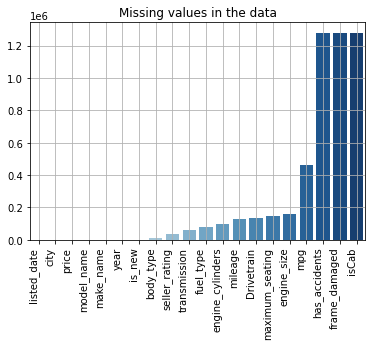

In [15]:
def clean_data(data, plot=False):
    """Filters the data by the make count, drops some columns like listed date, listed year and then
    renamed some of the columns

    Args:
        make_count (int): number of make to filter by
    Returns:
        Clean dataframe
    """
    import time
    import pandas as pd
    import numpy as np
    start = time.time()
    # Filtering the data
    print("-------------------------------------")
    print("|        Started Data Cleaning       |")
    print("-------------------------------------")

    data = data.drop(["Unnamed: 0","listed_year"],axis=1)

    # Data Cleaning
    print("-------------------------------------")
    print("Progress: Cleaning data")
    cleaning_time_start = time.time()
    data["maximum_seating"] = data["maximum_seating"].apply(lambda seating: str(seating).strip().split(" ")[0])
    data["transmission"] = data["transmission"].apply(lambda trans: str(trans).replace("A","Automatic").replace("M","Manual"))
    data["engine_displacement"] = data["engine_displacement"].apply(lambda disp: disp/1000)
    data["engine_cylinders"] = data["engine_cylinders"].apply(lambda cyl: str(cyl).strip().split(" ")[0].strip())
    data["mpg"] = (data["city_fuel_economy"] + data["highway_fuel_economy"])/2

    data = data.drop(columns=["city_fuel_economy", "highway_fuel_economy"])

    # Replacing every nan inputed through cleaning with np.nan
    data["engine_cylinders"] = data["engine_cylinders"].replace({"nan": np.nan,"--":np.nan})
    data["transmission"] = data["transmission"].replace({"nan":np.nan,"--":np.nan})
    data["maximum_seating"] = data["maximum_seating"].replace({"nan":np.nan,"--":np.nan})

    # Changing datatype
    data["is_new"] = data["is_new"].astype(str)
    data['maximum_seating'] = data['maximum_seating'].astype(float)

    cleaning_time_end = time.time()
    print("Cleaned data | Time taken {}".format(str(cleaning_time_end-cleaning_time_start)))
    print("-------------------------------------\n")
    print("-------------------------------------")
    print("Progress: Renaming data")
    # Renaming some columns
    renaming_start = time.time()
    data = data.rename(columns={"fuel_tank_volume":"Tank_Volume",
                                "engine_displacement":"engine_size",
                                "wheel_system":"Drivetrain"})
    renaming_end = time.time()
    print("Data Renamed | Time taken {}".format(str(renaming_end-renaming_start)))
    print("-------------------------------------\n")
    end= time.time()
    print("-------------------------------------")
    print("Total Time Taken for Process: {}".format(str(end-start)))
    print("-------------------------------------")

    # For plotting the graph
    if plot is True:
        missing_index = data.isnull().sum().sort_values(ascending=True).index
        missing_values = data.isnull().sum().sort_values(ascending=True).values

        sns.barplot(x=missing_index, y=missing_values,palette="Blues")
        plt.xticks(rotation=90,horizontalalignment="right")
        plt.title("Missing values in the data")
        plt.grid()
        plt.show()


    return data

# Cleaning the data
cleaned_data = clean_data(data, plot=True)

## Visualization

In [16]:
def create_plot(data, first_col, plot_type=None, second_col=None, hue=None, plot=None, plot_style=None):
    """Creates Univariate, Bivariate and Multivariate plot for comparing a feature with another

    Parameter:
        data [Dataframe]: Dataframe to be used for plotting the graph
        first_col (object): first
    
    Return:
        compared plot
    """

    import matplotlib.pyplot as plt 
    import seaborn as sns

    # Defining the plot_type
    plots_ = ["Univariate","Bivariate","Multivariate"]
    plot_styles = []
    # data_columns = list(data.columns)
    data_columns = [feature for feature in data.columns]

    if first_col not in data_columns:
        raise KeyError("Column entered not in Dataframe here are the column list {}".format(
            [feature for feature in data_columns if feature != second_col]))
    if second_col not in data.columns:
        raise KeyError("Column entered not in Dataframe here are the column list {}".format(
            [feature for feature in data_columns if feature != first_col]))
    if plot_type not in plots_:
        raise KeyError("Invalid Plot Type \n Choose Between {}".format(plots_))
    if plot_type.title() == "Multivariate" and hue is None:
        raise ValueError("You have to choose the third column to plot with, which include {}".format(
                                        [feature for feature in data_columns if feature != first_col]))

    # For the bivariate plot 
    if plot_type == "Univariate":
        if data[first_col].dtype != object:
            raise KeyError("feature must be an object type")
        # Plotting the graph
        sns.countplot(data[first_col], palette="Blues")
        plt.title("{} sample in the dataset".format((" ".join(first_col.split("_")).title())))
        plt.xticks(rotation=45, horizontalalignment="right")
        plt.show()

    if plot_type == "Bivariate":
        if data[first_col].dtype == object and data[second_col].dtype == object:
            raise KeyError("Both Input feature cannot be object, either first input or second must be an object")
        if data[first_col].dtype == object and data[second_col].dtype != object:
            first_col_name = (" ".join(first_col.split("_"))).title()
            second_col_name = (" ".join(second_col.split("_"))).title()
            plt.figure(figsize=(22,5))
            grouped_index = data.groupby(first_col)[second_col].mean().sort_values(ascending=True).index
            grouped_values = data.groupby(first_col)[second_col].mean().sort_values(ascending=True).values

            sns.barplot(grouped_index,grouped_values,palette="Blues")
            plt.xlabel((" ".join(first_col.split("_"))).title())
            plt.title("Comparing the aggregate of {} with the {}".format(second_col_name,first_col_name))
            plt.xticks(rotation=45, horizontalalignment="right")
            plt.grid()
            plt.show()

    
        if data[first_col].dtype != object and data[second_col].dtype == object:
            first_col_name = (" ".join(first_col.split("_"))).title()
            second_col_name = (" ".join(second_col.split("_"))).title()
            plt.figure(figsize=(22,5))
            grouped_index = data.groupby(second_col)[first_col].mean().sort_values(ascending=True).index
            grouped_values = data.groupby(second_col)[first_col].mean().sort_values(ascending=True).values

            sns.barplot(grouped_index,grouped_values,palette="Blues")
            plt.xlabel((" ".join(first_col.split("_"))).title())
            plt.title("Comparing the aggregate of {} with the {}".format(first_col_name,second_col_name))
            plt.xticks(rotation=45, horizontalalignment="right")
            plt.grid()
            plt.show()


        if data[first_col].dtype != object and data[second_col].dtype != object:
            plt.figure(figsize=(22,5))
            sns.scatterplot(data[first_col], data[second_col], palette="Blues")
            plt.title("")
            plt.grid()
            plt.show()

    if plot_type == "Multivariate":

        # if plot not in plot_styles:
        #     raise KeyError("Invalid Plot style selected: Enter either one of these {}".format(plot_styles))
        if data[hue].dtype != object:
            raise TypeError("feature chosen as Hue must be an object. You can use one of these {}".format(
                        feature for feature in data.columns if data[feature].dtype == object and feature not in [first_col, second_col]))
        
        hue_ = []
        first_col_ = []
        second_col_ = []
        if data[first_col].dtype == object and data[second_col].dtype != object:
            grouped = data.groupby([first_col,hue])[second_col].mean()
            for hues,first,second in grouped:
                hue_.append(hues)
                first_col_.append(first)
                second_col_.append(second)
            sns.barplot(x=first_col_,y=second_col_,hue=hue_,palette="Blues")

        if data[first_col].dtype != object and data[second_col].dtype != object:
            sns.scatterplot(data[first_col], data[second_col],hue=data[hue])
            plt.show()

        if data[first_col].dtype == object or data[second_col].dtype == object:
            sns.barplot(data, first_col, second_col, hue=hue, palette="Blues")
            plt.grid()
            plt.show()



In [ ]:
create_plot(cleaned_data,first_col="engine_cylinders",second_col="price",hue ="is_new", plot_type="Multivariate")

TypeError: ignored

In [ ]:
cleaned_data.head()

,body_type,city,engine_cylinders,engine_size,frame_damaged,fuel_type,has_accidents,isCab,is_new,make_name,maximum_seating,mileage,model_name,price,seller_rating,transmission,Drivetrain,year,mpg
1,SUV / Crossover,San Juan,I4,2.0,NaN,Gasoline,NaN,NaN,True,Land Rover,7.0,8.0,Discovery Sport,46500.0,3.0,Automatic,AWD,2020,NaN
3,SUV / Crossover,San Juan,V6,3.0,NaN,Gasoline,NaN,NaN,True,Land Rover,7.0,11.0,Discovery,67430.0,3.0,Automatic,AWD,2020,NaN
4,SUV / Crossover,San Juan,I4,2.0,NaN,Gasoline,NaN,NaN,True,Land Rover,7.0,7.0,Discovery Sport,48880.0,3.0,Automatic,AWD,2020,NaN
5,SUV / Crossover,San Juan,I4,2.0,False,Gasoline,False,False,True,Land Rover,5.0,12.0,Range Rover Velar,66903.0,3.0,Automatic,AWD,2020,NaN
7,SUV / Crossover,San Juan,I4,2.0,NaN,Gasoline,NaN,NaN,True,Land Rover,5.0,11.0,Range Rover Velar,68520.0,3.0,Automatic,AWD,2020,NaN


In [ ]:
cleaned_data.to_csv("used_data_interim.csv")

In [ ]:
cleaned_data.shape

(2787109, 19)

# Dealing with missing values

## Removing datapoint with high record of missing value

In [ ]:
# def del_records(data, thresh: int):
#     """Removes datapoint with number of missing records exceeding the threshold given

#     Args:
#         thresh (int): Threshold for which the datapoint is deleted
#     Raises:
#         ValueError: if the threshold given is more than the number of rows in the dataframe
#     """
#     if thresh > len(data.columns):
#         raise ValueError(f"Threshold is more than the size of the dataframe row Please choose between 1 and {len(data.columns)}")
#     index = []
#     print("<number of records: {}>".format(len(data)))
#     print("----------------------------------------------------")
#     print("|               Datapoint Deletion                   |")
#     print("----------------------------------------------------")
#     start = time.time()
#     for i in range(len(data)):
#         missing_ = 0
#         for j in range(len(data.columns)):
#             if pd.isna(data.iloc[i,j]) == True:
#                 missing_ +=1
                
#         if missing_ >= thresh:
#             data = data.drop(int(i))
#             # index.append(str(i))
#             print("Progress: removed index {}".format(i))
#         missing_ = 0

#     end = time.time()
#     print("----------------------------------------------------------------------")
#     print("Done!...Number of Records removed: {} | Time Taken {}".format(len(index),str(end-start)))
#     print("-----------------------------------------------------------------------")
#     return data

# indexes = del_records(dummy,thresh=2)

## Imputing missing values

In [17]:
def rec_missing_values(new_data):

    # Trimming some records with null val
    new_data = new_data[new_data["body_type"].notnull()]
    new_data = new_data[new_data["transmission"].notnull()]
    new_data = new_data[new_data["Drivetrain"].notnull()]


    new_data["seller_rating"] = new_data["seller_rating"].fillna(new_data["seller_rating"].mean())
    new_data["isCab"] = new_data["isCab"].fillna(new_data["isCab"].mode()[0])
    new_data["is_new"] = new_data["is_new"].fillna(new_data["is_new"].mode()[0])
    new_data["maximum_seating"] = new_data["maximum_seating"].fillna(new_data["maximum_seating"].mode()[0])
    new_data["mileage"] = new_data["mileage"].fillna(new_data["mileage"].mean())
    new_data["has_accidents"] = new_data["has_accidents"].fillna(new_data["has_accidents"].mode()[0])
    new_data["fuel_type"] = new_data["fuel_type"].fillna(new_data["fuel_type"].mode()[0])
    new_data["engine_cylinders"] = new_data["engine_cylinders"].fillna(new_data["engine_cylinders"].mode()[0])
    new_data["engine_size"] = new_data["engine_size"].fillna(new_data["engine_size"].mode()[0])
    new_data["mpg"] = new_data["mpg"].fillna(new_data["mpg"].mode()[0])
    
    new_data = new_data.drop(columns=["frame_damaged"])
    return new_data
imputed_data = rec_missing_values(cleaned_data)

In [ ]:
imputed_data.head()

,body_type,city,engine_cylinders,engine_size,fuel_type,has_accidents,isCab,is_new,listed_date,make_name,maximum_seating,mileage,model_name,price,seller_rating,transmission,Drivetrain,year,mpg
1,SUV / Crossover,San Juan,I4,2.0,Gasoline,False,False,True,2020-02-15,Land Rover,7.0,8.0,Discovery Sport,46500.0,3.0,Automatic,AWD,2020,28.5
3,SUV / Crossover,San Juan,V6,3.0,Gasoline,False,False,True,2020-02-26,Land Rover,7.0,11.0,Discovery,67430.0,3.0,Automatic,AWD,2020,28.5
4,SUV / Crossover,San Juan,I4,2.0,Gasoline,False,False,True,2020-04-25,Land Rover,7.0,7.0,Discovery Sport,48880.0,3.0,Automatic,AWD,2020,28.5
5,SUV / Crossover,San Juan,I4,2.0,Gasoline,False,False,True,2020-01-11,Land Rover,5.0,12.0,Range Rover Velar,66903.0,3.0,Automatic,AWD,2020,28.5
7,SUV / Crossover,San Juan,I4,2.0,Gasoline,False,False,True,2020-07-01,Land Rover,5.0,11.0,Range Rover Velar,68520.0,3.0,Automatic,AWD,2020,28.5


# Feature Engineering

- Automating more feature using the Deep Feature Synthesis

In [1]:
! pip install featuretools

     |████████████████████████████████| 336 kB 5.3 MB/s 
     |████████████████████████████████| 160 kB 38.1 MB/s 
     |████████████████████████████████| 280 kB 50.9 MB/s 
     |████████████████████████████████| 11.3 MB 49.8 MB/s 
     |████████████████████████████████| 802 kB 54.7 MB/s 
     |████████████████████████████████| 1.0 MB 54.3 MB/s 
     |████████████████████████████████| 596 kB 49.9 MB/s 
     |████████████████████████████████| 132 kB 53.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8
  Attempting uninstall: pandas
    Found existing installation:

In [ ]:
import featuretools as ft

In [19]:
import featuretools as ft

def feature_synthesis(data):

    es = ft.EntitySet(id ='used_car')

        es.entity_from_dataframe(entity_id="used_car",
                                dataframe=data,
                                index=True,
                                Index="id",
                                time_index='listed_date')

    # creating

    # Adding relationship 

    es.add_relationship(parent_dataframe_name='used_car', 
                        parent_column_name='id', 
                        child_dataframe_name='listing', 
                        child_column_name='listing_id')


    # Run deep feature synthesis with transformation primitives
    # feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity = 'used_car_data',
                                        #   trans_primitives = ['add_numeric', 'multiply_numeric'])

    # feature_matrix.head()

AttributeError: ignored

In [ ]:
es

Entityset: used_car
  DataFrames:
    used_car_data [Rows: 2598200, Columns: 20]
  Relationships:
    No relationships